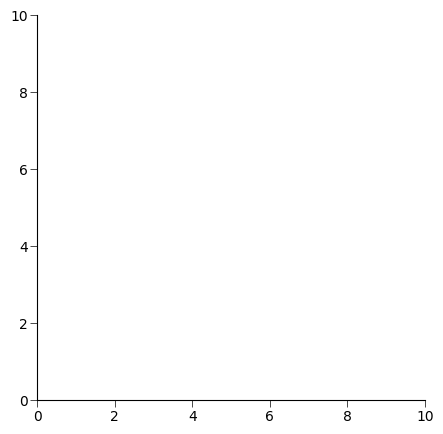

In [1]:
import scanpy as sc
import numpy as np
import operator
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import os
#setPltLinewidth(0)
# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,6,7"

from torch.nn import DataParallel
import os
import anndata as ad
import cospar as cs
import scanpy as sc
def createFig(figsize=(8, 4)):
    fig,ax=plt.subplots()           
    ax.spines['right'].set_color('none')     
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')     
    #ax.spines['left'].set_color('none')
    for line in ax.yaxis.get_ticklines():
        line.set_markersize(5)
        line.set_color("#585958")
        line.set_markeredgewidth(0.5)
    for line in ax.xaxis.get_ticklines():
        line.set_markersize(5)
        line.set_markeredgewidth(0.5)
        line.set_color("#585958")
    ax.set_xbound(0,10)
    ax.set_ybound(0,10)
    fig.set_size_inches(figsize)
    return fig,ax
def setPltLinewidth(linewidth:float):
    mpl.rcParams['axes.linewidth'] = linewidth
import matplotlib as mpl
fig,ax=createFig()
fig.set_size_inches(5,5)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
setPltLinewidth(1)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1
adata =cs.hf.read('/home/zhengtuo/songtao/weinreb_noclone.h5ad')


In [25]:
adata.X

<49116x25289 sparse matrix of type '<class 'numpy.float32'>'
	with 71079357 stored elements in Compressed Sparse Row format>

In [2]:
adata.obs['index']=range((adata.shape[0]))
adata.obs['index']=adata.obs.index.astype(int)
adata.obs['time_info']=adata.obs['time_info'].astype(int)
adata.obs['time_info'] = adata.obs['time_info'].replace(24, 2)


In [3]:
dic_true={}
adata.obs['GT']=None
for i in range((adata.shape[0])):
    if(adata.obs['NeuMon_fate_bias'][i]>0.5):
        dic_true[adata.obs['index'][i]]=1
        if(adata.obs['state_info'][i]=='undiff'):
            adata.obs['GT'][i]='Neu'
    elif(adata.obs['NeuMon_fate_bias'][i]<0.5):
        dic_true[adata.obs['index'][i]]=0
        if(adata.obs['state_info'][i]=='undiff'):
            adata.obs['GT'][i]='Mo'
    else:
        if(adata.obs['state_info'][i]=='undiff'):
            dic_true[adata.obs['index'][i]]=2
#adata.obs['GT'].value_counts()

/tmp/ipykernel_27189/3140920558.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['GT'][i]='Neu'
/tmp/ipykernel_27189/3140920558.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['GT'][i]='Mo'


In [4]:

import numpy as np
import pandas as pd

clone_matrix = adata.obsm['X_clone'].toarray()

# 获取时间、状态信息和 NeuMon_fate_bias
time_info = adata.obs['time_info']
state_info = adata.obs['state_info']
neumon_fate_bias = adata.obs['NeuMon_fate_bias']

# 创建结果列表
results = []

# 遍历克隆矩阵
for clone_id in range(clone_matrix.shape[1]):
    # 获取属于这个克隆的所有细胞
    cells_in_clone = np.where(clone_matrix[:, clone_id] == 1)[0]
    
    # 获取这个克隆中的 undiff 细胞 (时间点为 2 或 4，且 NeuMon_fate_bias != 0.5)
    undiff_cells = [cell for cell in cells_in_clone if state_info[cell] == 'undiff' 
                    and time_info[cell] in [2] 
                    and neumon_fate_bias[cell] != 0.5]
    
    # 获取这个克隆中的分化细胞 (时间点大于 2)
    diff_cells = [cell for cell in cells_in_clone if state_info[cell] != 'undiff' and time_info[cell] !=2]
    
    # 生成关系
    for undiff_cell in undiff_cells:
        for diff_cell in diff_cells:
            if time_info[diff_cell] > time_info[undiff_cell]:
                results.append({
                    'cell1': undiff_cell,
                    'cell1_type': state_info[undiff_cell],
                    'cell1_day': time_info[undiff_cell],
                    'cell2': diff_cell,
                    'cell2_type': state_info[diff_cell],
                    'cell2_day': time_info[diff_cell],
                    'clone_id': clone_id
                })

# 创建 DataFrame
df = pd.DataFrame(results)

# 保存为 CSV 文件
#df.to_csv('/home/zhengtuo/songtao/clone_relations.csv', index=False)

print(df.head())

   cell1 cell1_type  cell1_day  cell2  cell2_type  cell2_day  clone_id
0   4786     undiff          2      2    Monocyte          6         2
1   6305     undiff          2     18  Neutrophil          6        18
2   5292     undiff          2     81    Monocyte          6        81
3  34655     undiff          2     85  Neutrophil          6        85
4   5620     undiff          2     86  Neutrophil          6        86


In [11]:
df['clone_id'].value_counts()

2        1
22528    1
20191    1
20188    1
20187    1
        ..
10589    1
10580    1
10559    1
10515    1
29566    1
Name: clone_id, Length: 1667, dtype: int64

In [10]:
df[df['clone_id']==2]

cell1 cell1_type  cell1_day  cell2 cell2_type  cell2_day  clone_id
0   4786     undiff          2      2   Monocyte          6         2

In [14]:
#开始训练！！！！！！！！
#df = final_df
#df=df[df['cell1'].isin(adata_disp.obs.index.astype(int))]
import random
df2 = df[(df['cell1_type'] == 'undiff') & (df['cell2_type'] != 'undiff') & (df['cell2_type'] != 'Neu_Mon')]
df2=df2[(df2['cell2_type']!='Meg')&(df2['cell2_type']!='Erythroid')&(df2['cell2_type']!='pDC')]

df2 = [df for _, df in df2.groupby('clone_id')]
random.shuffle(df2)
print(len(df2)*0.7)
len_train=1128#len(a)*0.7 1317
len_test=len(df2)-len_train#len(a)-len_train 565
cell_day2_all=list(set(list(df['cell1'])))
cell_day46_all=list(set(list(df['cell2'])))
dic_sameBC={}
for j in df2:
    item1=(j.values.T[0])
    item2=list(set(j.values.T[3]))
    for i in item1:
        dic_sameBC[i]=item2

1128.3999999999999


In [21]:
#Construct Triplet
testcell1=[]
testcell2=[]
traincell1=[]
traincell2=[]
train_rel=[]
test_rel=[]

dic={'Monocyte':0, 'Neutrophil':1, 'Lymphoid':2,'Mast':3, 'Ccr7_DC':4,
       'Baso':5, 'Eos':6}
# dic={'Monocyte':0, 'Neutrophil':0, 'Lymphoid':0,'Mast':0, 'Ccr7_DC':0,
# 'Baso':0, 'Eos':0}

# a=df.groupby('lineage_id')
for i in range(0,10):
    sum_train=0
    for j in df2:
        if(sum_train<len_train):
            cell1_index=j['cell1'].values
            cell2_index=j['cell2'].values
            sum_train+=1
            for count in range(len(cell1_index)):
                if(j['cell2_type'].values[count]!='unidff'):
                    #if(j['cell2_type'].values[count]=='Monocyte' or j['cell2_type'].values[count]=='Neutrophil'):
                        train_rel.append(dic[j['cell2_type'].values[count]])
                        traincell1.append(cell1_index[count])
                        traincell2.append(cell2_index[count])
        else:
            cell1_index=j['cell1'].values
            cell2_index=j['cell2'].values
            sum_train+=1
            for count in range(len(cell1_index)):
                if(j['cell2_type'].values[count]!='undiff'):
                    #dic_sameBC[cell1_index[count]].append(cell2_index[count])
                    #dic_sameBC[cell1_index[count]]=cell2_index
                    test_rel.append(dic[j['cell2_type'].values[count]])
                    testcell1.append(cell1_index[count])
                    testcell2.append(cell2_index[count])




In [22]:
##No relation的生成  5 3
num=25
from_index=list(set(traincell1))
for i in range(len(set(from_index))):
    print(i)
    a1=[]
    a1.append(from_index[i])
    cell1=np.random.choice(a1,num,replace=True)
    cell1=list(cell1)
    cell2_choice=set(traincell2)-set(dic_sameBC[cell1[0]])
    cell2=np.random.choice(list(set(cell2_choice)),num,replace=False)
    cell2=list(cell2)
    rel=np.random.choice([7],num,replace=True)
    rel=list(rel)
    traincell1+=cell1
    traincell2+=cell2
    train_rel+=rel

from_index=list(set(testcell1))
num=25
for i in range(len(set(from_index))):
    print(i)
    a1=[]
    a1.append(from_index[i])
    cell1=np.random.choice(a1,num,replace=True)
    cell1=list(cell1)
    cell2_choice=set(testcell2)-set(dic_sameBC[cell1[0]])
    cell2=np.random.choice(list(set(cell2_choice)),num,replace=False)
    cell2=list(cell2)
    rel=np.random.choice([7],num,replace=True)
    rel=list(rel)
    testcell1+=cell1
    testcell2+=cell2
    test_rel+=rel

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [23]:
dic_train={}
dic_test={}
for i in train_rel:  
    dic_train[i] = dic_train.get(i, 0) + 1
print(dic_train) 
for i in test_rel:  
    dic_test[i] = dic_test.get(i, 0) + 1
print(dic_test)


{5: 1910, 1: 4370, 0: 4470, 3: 390, 2: 40, 6: 90, 4: 10, 7: 28200}
{0: 2020, 1: 1800, 6: 30, 5: 820, 3: 140, 2: 20, 4: 10, 7: 12100}


In [24]:
np.savetxt('/home/zhengtuo/songtao/2traincell1.txt',traincell1)
np.savetxt('/home/zhengtuo/songtao/2traincell2.txt',traincell2)
np.savetxt('/home/zhengtuo/songtao/2testcell1.txt',testcell1)
np.savetxt('/home/zhengtuo/songtao/2testcell2.txt',testcell2)
np.savetxt('/home/zhengtuo/songtao/2trainrel.txt',train_rel,fmt='%d')
np.savetxt('/home/zhengtuo/songtao/2testrel.txt',test_rel,fmt='%d')


In [26]:
###### from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from math import sqrt
from random import choice
from torch.utils.data  import Dataset, DataLoader
import pandas as pd
#from layers import SinkhornDistance
num_relations=8
len_geneExp=25289
len_embedding=256
learning_rate=0.0001
num_epoch=50
batchsize=512

criterion_rec = nn.MSELoss()
geneEnc=nn.Sequential(
        nn.Dropout(),
        nn.Linear(len_geneExp, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
         nn.Linear(100, len_embedding),
    )

geneDec = nn.Sequential(
    nn.Linear(len_embedding, 512),
    nn.Linear(512, len_geneExp),
)
genemap = nn.Sequential(
     #nn.Dropout(),
     nn.Linear(len_embedding, 100),
     nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, len_embedding),

)
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(inplace=False),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        #print('channel:',c)
        #print('size:',x.shape)
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        #print('y_size:',y.shape)
        return x * y.expand_as(x)
class MutiheadAttention(nn.Module):
    def __init__(self, input_dim, dim_k, dim_v,num_heads):
        super(MutiheadAttention, self).__init__()
        self.dim_q = dim_k # 一般默认 Q=K
        self.dim_k = dim_k
        self.dim_v = dim_v
        self.num_units=dim_k
        self.num_heads=num_heads
        #定义线性变换函数
        self.linear_q = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_k = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_v = nn.Linear(input_dim, dim_v, bias=False)
        self._norm_fact = 1 / sqrt(dim_k)

    def forward(self, x):
        # x: batch_size, seq_len, input_dim
        q = self.linear_q(x)  # batch_size, seq_len, dim_k
        k = self.linear_k(x)  # batch_size, seq_len, dim_k
        v = self.linear_v(x)  # batch_size, seq_len, dim_v
        split_size = self.num_units // self.num_heads
        q = torch.stack(torch.split(q, split_size, dim=2), dim=0)  # [h, N, T_q, num_units/h]
        k = torch.stack(torch.split(k, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]
        v = torch.stack(torch.split(v, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]

        scores = torch.matmul(q, k.transpose(2, 3))
        scores = scores / (self.dim_k ** 0.5)
        
        scores = F.softmax(scores, dim=3)
        ## out = score * V
        out = torch.matmul(scores, v)  # [h, N, T_q, num_units/h]
        out = torch.cat(torch.split(out, 1, dim=0), dim=3).squeeze(0) 

        return out

class ResidualBlock(torch.nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        self.conv1 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.se=SELayer(channels,16)
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        y=self.se(y)
        return F.relu(x+y)

class DestinyNet(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.att=MutiheadAttention(len_embedding*2,512,512,64)
        self.layernorm=nn.LayerNorm(512)
        self.conv1 = nn.Conv1d(1, 32, 4)  # 输入通道数为1，输出通道数为6
        self.relu1=nn.LeakyReLU(0.2, inplace=True)
        self.rblock1 = ResidualBlock(32)
        self.conv2 = nn.Conv1d(32,64, 4)  # 输入通道数为6，输出通道数为16
        self.batchn1=nn.BatchNorm1d(64)
        self.relu2= nn.LeakyReLU(0.2, inplace=True)
        self.rblock2 = ResidualBlock(64)
        self.conv3=nn.Conv1d(64,128,4)
        self.batchn2=nn.BatchNorm1d(128)
        self.relu3= nn.LeakyReLU(0.2, inplace=True)
        self.rblock3 = ResidualBlock(128)
        self.conv4=nn.Conv1d(128,256,4)
        self.batchn3=nn.BatchNorm1d(256)
        self.relu4= nn.LeakyReLU(0.2, inplace=True)
        self.rblock4 = ResidualBlock(256)
        self.dropout=nn.Dropout()
        self.fc1 = nn.Linear(7424, num_relations)
        
    def forward(self, x):
        # 输入x -> conv1 -> relu -> 2x2窗口的最大池化
        x=self.att(x)+x
        x=self.layernorm(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock1(x)
        # # 输入x -> conv2 -> relu -> 2x2窗口的最大池化
        x = self.conv2(x)
        x=self.batchn1(x)
        x=self.relu2(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock2(x)
        
        x = self.conv3(x)
        x=self.batchn2(x)
        x=self.relu3(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock3(x)
        
        x = self.conv4(x)
        x=self.batchn3(x)
        x=self.relu4(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock4(x)
        # # view函数将张量x变形成一维向量形式，总特征数不变，为全连接层做准备
        x = x.view(x.size()[0], -1)
        x=self.dropout(x)
        x=self.fc1(x)
        return x
class TrainDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        cell1_id=int(traincell1[idx])
        cell2_id=int(traincell2[idx])
        gene1=adata_orig.X[cell1_id]
        gene1=torch.tensor(gene1)
        gene2=adata_orig.X[cell2_id]
        gene2=torch.tensor(gene2)       
        genetype=train_rel[idx]
        #genetype=dic1[genetype]
        genetype=torch.tensor(genetype)
        return gene1,gene2,genetype

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
model=DestinyNet()
optimizer = torch.optim.Adam(
    [{'params': geneEnc.parameters()},
    {'params': model.parameters()},
        {'params': geneDec.parameters()},
    #{'params': norelmodel.parameters()},
            {'params': genemap.parameters()}],
    lr=learning_rate)
from sklearn.metrics import confusion_matrix
TwoNets_path='/home/zhengtuo/songtao/weinreb_noclone.pth'
checkpoint = torch.load(TwoNets_path,map_location='cuda:1')
device2=torch.device("cuda:1")
device=torch.device("cuda:1")

model.load_state_dict(checkpoint['model'])
model.to(device2)
geneEnc.load_state_dict(checkpoint['geneEnc'])
geneEnc.to(device2)
geneDec.load_state_dict(checkpoint['geneDec'])
geneDec.to(device2)

model.eval()
geneEnc.eval()
geneDec.eval()

genemap.load_state_dict(checkpoint['genemap'])
genemap.to(device2)
genemap.eval()



Sequential(
  (0): Linear(in_features=256, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=100, out_features=256, bias=True)
)

In [28]:
adata.X=adata.X.toarray()

In [29]:
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd
from torch.autograd import Variable
import scanpy as sc
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt


mapembedding = []
all_embeddings = []
geneEnc.to(device)
genemap.to(device)

Embeddings_path = '/home/zhengtuo/newdata1-cnn.pth.txt' # txt dir to save cell embeddings

with torch.no_grad():
    for i in trange(adata.shape[0]):
        x = adata.X[i]
        geneExp = torch.tensor(x).to(device)
        geneExp=torch.reshape(geneExp,(1,adata.shape[1]))
        geneExp = geneExp.to(torch.float32)
        geneEmbedding = geneEnc(geneExp)
        mapEmbedding=genemap(geneEmbedding)
        mapEmbedding = mapEmbedding.cpu().detach().numpy()
        geneEmbedding = geneEmbedding.cpu().detach().numpy() # or any other data type
        all_embeddings.append(geneEmbedding)
        mapembedding.append(mapEmbedding)
    np.savez(Embeddings_path,all_embeddings)
all_embeddings=np.array(all_embeddings)
mapembedding=np.array(mapembedding)

adata.obsm['geneEnc']=all_embeddings
adata.obsm['genemap']=mapembedding
#adata.obsm['X_pca']=adata.obsm['X_pca'].cpu().numpy()



100%|█████████████████████████████████████████████████████████████████████████████████████████| 49116/49116 [00:44<00:00, 1114.82it/s]


/home/zhengtuo/miniconda3/envs/jst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


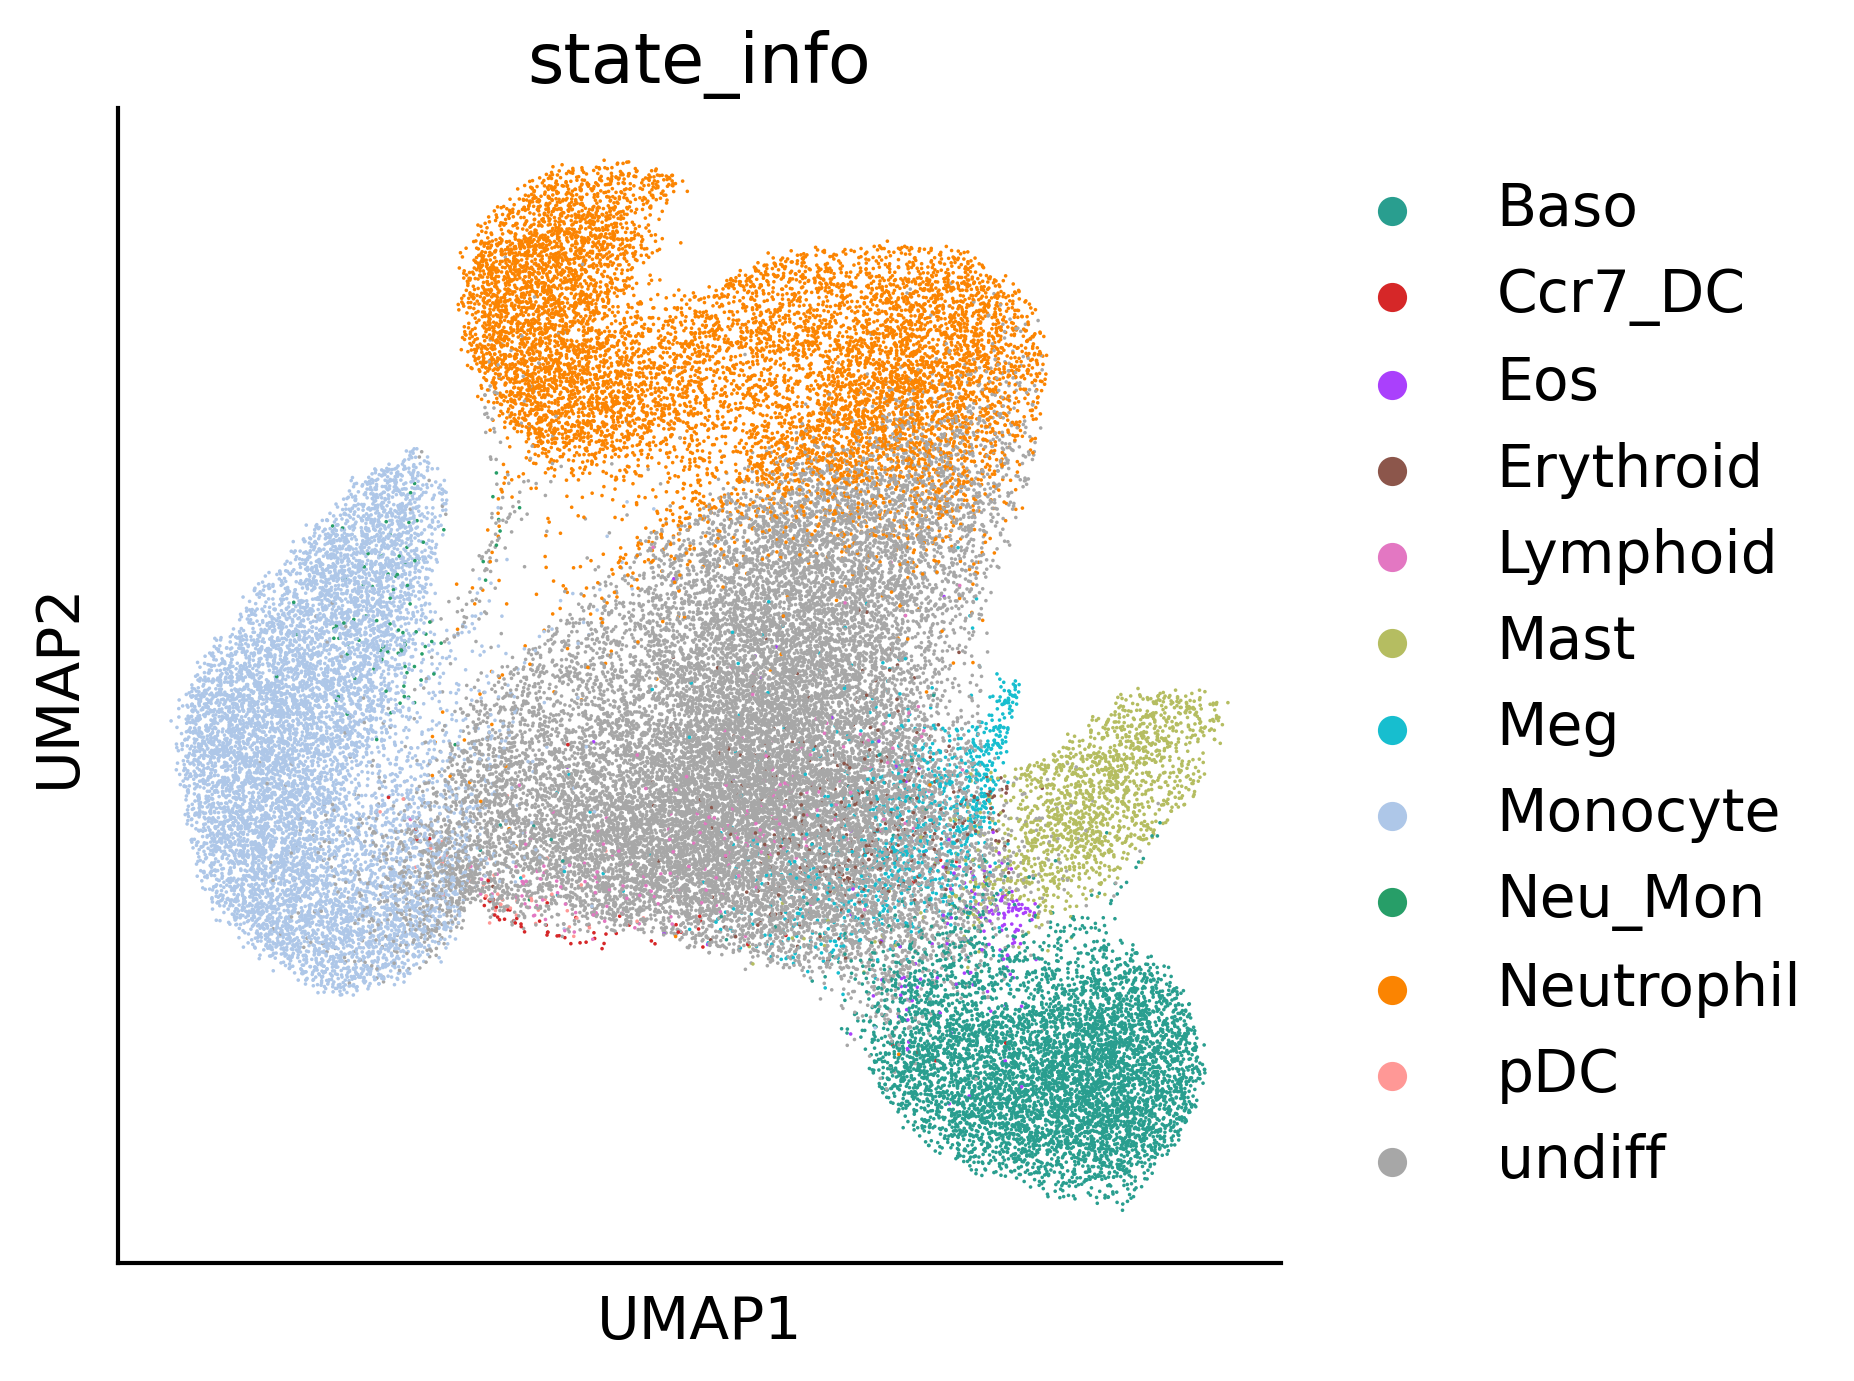

In [30]:
palette = dict(zip(sorted(np.unique(adata.obs['state_info'])), ['#299e8f', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#279e68', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2']))
palette['undiff'] = '#A7A7A7'
palette['Neutrophil'] = '#FB8401'
adata.uns['state_info_colors']=palette.values()
fig,ax=createFig()
fig.set_size_inches(5,5)
import torch
import umap
n= np.load("/home/zhengtuo/newdata1-cnn.pth.txt.npz")
n=torch.tensor(n['arr_0'])
n=torch.reshape(n,(adata.shape[0],256))
adata.obsm["X_pca"] = n

cs.pp.get_X_emb(adata, n_neighbors=20, umap_min_dist=1)
sc.pl.umap(adata, color="state_info",ax=ax,palette=palette, s=3)


In [91]:
traincell1=np.loadtxt('/home/zhengtuo/songtao/2traincell1.txt')
traincell2=np.loadtxt('/home/zhengtuo/songtao/2traincell2.txt')
testcell1=np.loadtxt('/home/zhengtuo/songtao/2testcell1.txt')
testcell2=np.loadtxt('/home/zhengtuo/songtao/2testcell2.txt')
train_rel=np.loadtxt('/home/zhengtuo/songtao/2trainrel.txt',dtype=int)
test_rel=np.loadtxt('/home/zhengtuo/songtao/2testrel.txt',dtype=int)

In [28]:
adata.X=adata.X.toarray()

In [31]:
dic_true={}
adata.obs['GT']=None
for i in range((adata.shape[0])):
    if(adata.obs['NeuMon_fate_bias'][i]>0.5):
        dic_true[adata.obs['index'][i]]=1
        adata.obs['GT'][i]='Mo'
    elif(adata.obs['NeuMon_fate_bias'][i]<0.5):
        dic_true[adata.obs['index'][i]]=0
        adata.obs['GT'][i]='Neu'
    else:
        dic_true[adata.obs['index'][i]]=2
# all_cell1=list(traincell1)+list(testcell1)
# all_cell2=list(traincell2)+list(testcell2)
all_cell1=list(traincell1)+list(testcell1)
all_cell2=list(traincell2)+list(testcell2)
# all_cell1=list(testcell1)
# all_cell2=list(testcell2)

from torch.utils.data import Dataset, DataLoader
class UndiffDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        i=int(list(set(all_cell1))[idx])
        #i = adata.obs.index.get_loc((i))
        gene = adata.X[i]
        gene=torch.tensor(gene)
        true_fate=dic_true[i]
        #genetype=dic1[genetype]
        true_fate=torch.tensor(true_fate)

        return gene,true_fate

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
class otherDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        i=int(list(set(all_cell2))[idx])
        #i = adata.obs.index.get_loc(str(i))

        gene = adata.X[i]

        gene=torch.tensor(gene)
        genetype=adata.obs['state_info'][i]
        genetype=dic[genetype]
        genetype=torch.tensor(genetype)
        return gene,genetype

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
def dup_rows(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)


unidffdataset = UndiffDataset(len(list(set(all_cell1))))
otherdataset=otherDataset(len(list(set(all_cell2))))
Undiffdataloader = DataLoader(unidffdataset, batch_size=len(list(set(all_cell1))), num_workers=4, shuffle=False, drop_last=False)
otherdataloader=DataLoader(otherdataset, batch_size=1, num_workers=4, shuffle=False, drop_last=False)

/tmp/ipykernel_27189/2678422875.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['GT'][i]='Mo'
/tmp/ipykernel_27189/2678422875.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['GT'][i]='Neu'


In [32]:
true=0
cudaid = 'cuda:6'
dic={'Monocyte':0, 'Neutrophil':1, 'Lymphoid':2,'Mast':3, 'Ccr7_DC':4,
       'Baso':5, 'Eos':6}
device2 = torch.device(cudaid)
geneEnc.to(device2)
model.to(device2)
for i, onebatch1 in enumerate(Undiffdataloader):
    cell1=onebatch1[0].to(device2)
    cell1=geneEnc(cell1)
    hang=cell1.shape[0]
    true_labels=onebatch1[1]
    pre=torch.zeros(hang)
    pre_labels=torch.zeros((hang,8))
    print(i)
    for j, onebatch2 in enumerate(otherdataloader):
        print(j)
        cell2=onebatch2[0].to(device2)
        cell2=geneEnc(cell2)
        cell2=dup_rows(cell2.cpu().detach().numpy(), indx=0,num_dups=hang-1)
        cell2=torch.tensor(cell2).to(device2)
        genetype=onebatch2[1]
        #print(genetype)
        geneEmbs = torch.cat((cell1, cell2), -1)
        geneEmbs=torch.reshape(geneEmbs,(geneEmbs.shape[0],1,geneEmbs.shape[1]))
        outputs = model(geneEmbs)
        outputs=torch.reshape(outputs,(hang,8))
        outputs=outputs.argmax(-1)

        for num in range(hang):
            if(int(outputs[num])!=7):
                pre_labels[num][int(outputs[num])]+=1
                #pre_labels[num][int(genetype)]+=1
        del outputs,cell2,genetype,geneEmbs
        torch.cuda.empty_cache()
    matrix1=pre_labels
    pre_labels=np.argsort(-pre_labels)
    pre_labels=pre_labels.T[0]
    true+=np.count_nonzero(pre_labels==true_labels)
    del cell1
    torch.cuda.empty_cache()
 


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [33]:
all_cell1=np.array(all_cell1).astype(int)
item=list(set(all_cell1))
dic_fate={}
for i in range(len(item)):
    dic_fate[item[i]]=pre_labels[i]
    

In [62]:
# 获取testcell1中的索引
# 处理all_cell1中的重复
unique_all_cell1 = list(set(all_cell1))

# 获取testcell1中的索引
test_indices = [i for i, cell in enumerate(unique_all_cell1) if cell in testcell1]

# 使用这些索引提取预测和真实标签的相应部分
test_true_labels = np.array(true_labels)
test_pre_labels = np.array(pre_labels)

# ... (其余代码不变)


# 初始化字典以进行统计
dic_fate1_test={}
dic_fate_true1_test={}
dic_pre1_test={}

# 计算预测准确率以及其他统计信息
for i in range(len(test_true_labels)):
    if(test_true_labels[i] == test_pre_labels[i]):
        dic_fate1_test[int(test_true_labels[i])] = dic_fate1_test.get(int(test_true_labels[i]), 0) + 1

for i in range(len(test_true_labels)):
    dic_fate_true1_test[int(test_true_labels[i])] = dic_fate_true1_test.get(int(test_true_labels[i]), 0) + 1

for i in range(len(test_pre_labels)):
    dic_pre1_test[int(test_pre_labels[i])] = dic_pre1_test.get(int(test_pre_labels[i]), 0) + 1

print("Test cell1 results:")
print(dic_fate1_test)
print(dic_fate_true1_test)
print(dic_pre1_test)

# 计算testcell1上的预测准确率
# accuracy_on_testcell1 = sum([dic_fate1_test[key] for key in [0,1]]) / len(set(testcell1))
# print("Accuracy on testcell1:", accuracy_on_testcell1)


Test cell1 results:
{0: 523, 1: 465}
{1: 787, 0: 825}
{5: 207, 0: 669, 1: 664, 3: 67, 6: 5}


In [58]:
# from cal_acc import cal_acc,cal_R
# print('acc:',cal_acc(true_labels,pre_labels))
# print('R:',cal_R(true_labels,pre_labels))
    

In [37]:
dic_fate={}
dic_true={}
dic_fate_prob={}
sum=0
for i in list(set(all_cell1)):
    i=int(i)
    a=matrix1[sum][0]
    b=matrix1[sum][1]
    item=float(b/(a+b))
    dic_fate_prob[i]=item
    dic_fate[i]=int(pre_labels[sum])
    dic_true[i]=int(true_labels[sum])
    sum+=1
    

In [38]:
adata.obs['fate_pred']='-'
#adata.obs['index']=adata.obs.index.astype(int)
adata.obs['fate_pred']=adata.obs['index'].map(dic_fate).fillna('-')
#adata.obs['fate_pred_prob']=adata.obs['index'].map(dic_fate_prob)
adata.obs['fate_pred'] = adata.obs['fate_pred'].astype('category')
adata.obs['fate_pred'].value_counts()


-      47504
0.0      669
1.0      664
5.0      207
3.0       67
6.0        5
Name: fate_pred, dtype: int64

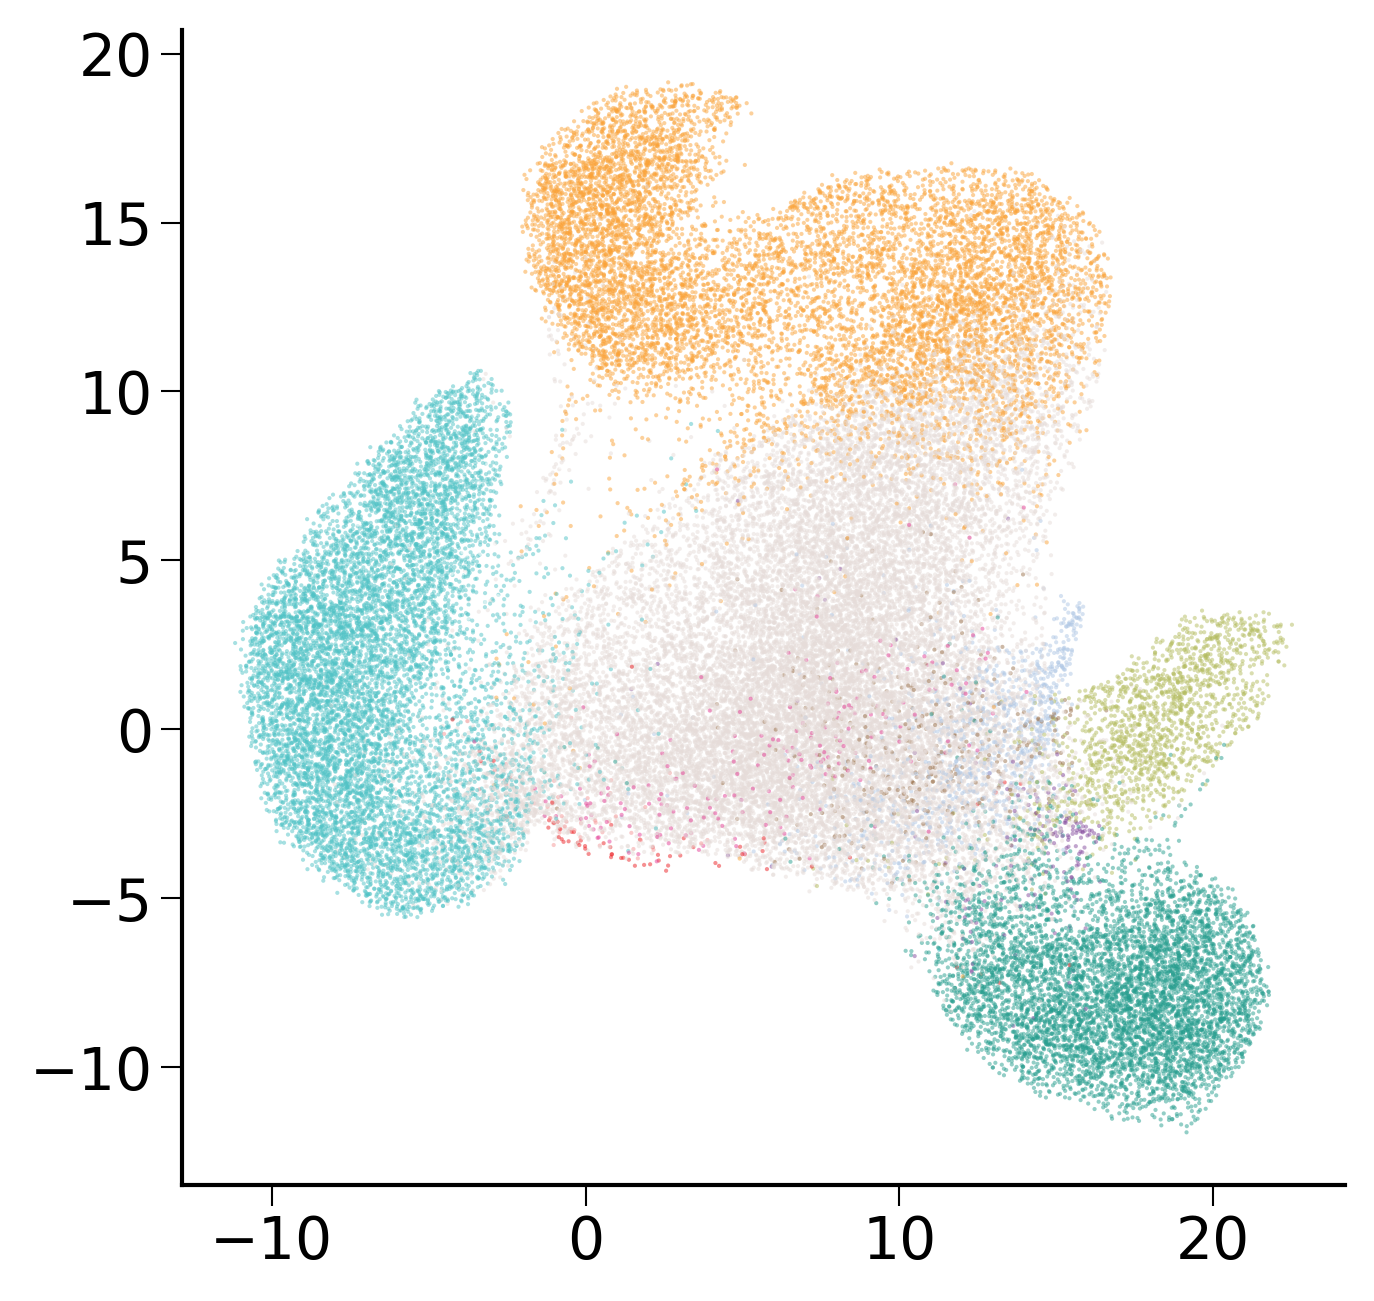

In [61]:
# cs.pl.embedding(adata, color="state_info",s=3)
import scanpy as sc
palette={
 'Baso': '#279E8F',
 'Ccr7_DC': '#ED2024',
 'Eos': '#854C9E',
 'Erythroid': '#9B724C',
 'Lymphoid': '#E43E96',
 'Mast': '#B5BD61',
 'Meg': '#AFC7E5',
 'Monocyte': '#50C3C6',
 'Neu_Mon': '#FFFFFF',
 'Neutrophil': '#FAA339',
 'pDC': '#F69696',
 'undiff': '#E6DCD9'
}
fig,ax=createFig()
fig.set_size_inches(5,5)
ax.scatter(
    adata.obsm["X_umap"][:,0],
    adata.obsm["X_umap"][:,1],
    c = list(map(lambda x: palette[x], adata.obs['state_info'])),
    s = 1,
    alpha=0.5,
    linewidths=0
)
ax.figure.savefig('/home/zhengtuo/songtao/DestinyNet/rebuttal6.1/noclone_fate_clustering.pdf', bbox_inches='tight')  # 修改为您的目标路径
plt.show()
plt.close(ax.figure)  # 关闭图形，释放资源


In [41]:
adata.obsm['X_pca']=adata.obsm['X_pca'].cpu().numpy()


In [76]:
weinreb_adata = adata.copy()
from collections import Counter

# our_prediction_all 指原文中所有的 undiff 细胞的 fate prediction 的版本
our_model_predictions = dic_fate
our_model_predictions = {int(k): v for k, v in our_model_predictions.items()}
weinreb_adata.obs['our_prediction_all'] = '-'  # 默认值为 '-'
weinreb_adata.obs.iloc[list(our_model_predictions.keys()), list(weinreb_adata.obs.columns).index('our_prediction_all')] = list(
    map(lambda x: 'Neu' if x == 1 else ('Mo' if x == 0 else '-'), our_model_predictions.values())
)

# 统计预测结果
Counter(weinreb_adata.obs['our_prediction_all'])

Counter({'-': 47783, 'Mo': 669, 'Neu': 664})

/home/zhengtuo/miniconda3/envs/jst/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/zhengtuo/miniconda3/envs/jst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


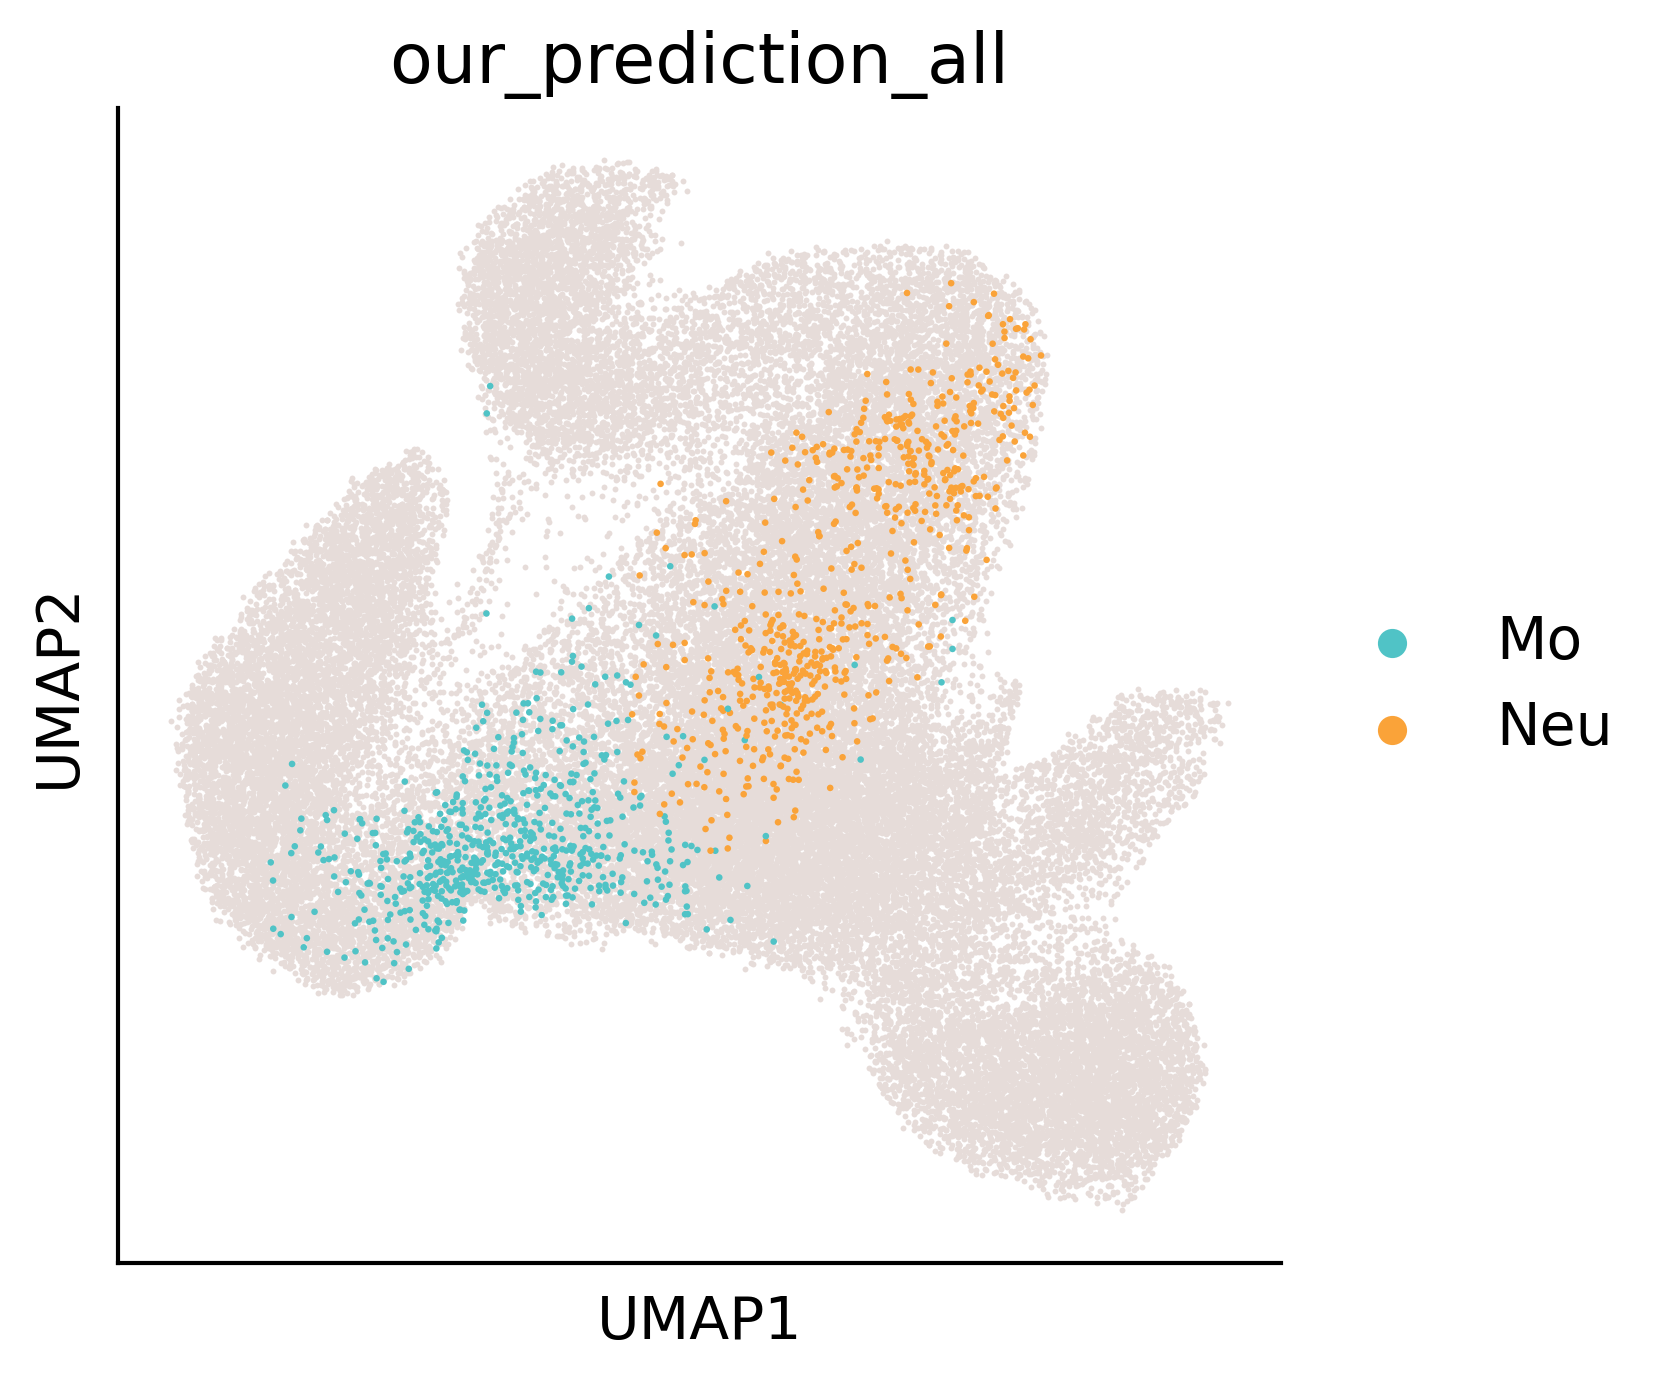

In [78]:
fig,ax=createFig()
fig.set_size_inches(5,5)
ax.scatter(
    weinreb_adata[weinreb_adata.obs['our_prediction_all'] == '-'].obsm["X_umap"][:,0],
    weinreb_adata[weinreb_adata.obs['our_prediction_all'] == '-'].obsm["X_umap"][:,1],
    s = 2, color='#E6DCD9', linewidth=0
)
sc.pl.umap(weinreb_adata[weinreb_adata.obs['our_prediction_all'] != '-'], 
           ax=ax, color='our_prediction_all', s=10, palette={
 'Baso': '#279E8F',
 'Ccr7_DC': '#ED2024',
 'Eos': '#854C9E',
 'Erythroid': '#9B724C',
 'Lymphoid': '#E43E96',
 'Mast': '#B5BD61',
 'Meg': '#AFC7E5',
 'Mo': '#50C3C6',
 'Neu_Mon': '#FFFFFF',
 'Neu': '#FAA339',
 'pDC': '#F69696',
 'undiff': '#E6DCD9',
 '-': '#E6DCD9'
})
ax.figure.savefig('/home/zhengtuo/songtao/DestinyNet/rebuttal6.1/noclone_fate_pred.pdf', bbox_inches='tight')  # 修改为您的目标路径
plt.show()
#plt.close(ax.figure)  # 关闭图形，释放资源


In [45]:
from colour import Color
from matplotlib.colors import LinearSegmentedColormap
def make_colormap( colors, show_palette = False ): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in colors ] )
    if show_palette:
        plt.figure( figsize = (15,3))
        plt.imshow( [list(np.arange(0, len( colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
        plt.xticks([])
        plt.yticks([])
    return color_ramp

In [63]:
#原文中有GT的undiff的细胞的fate GT的数量统计
#这个是从原始数据里面统计的GT的信息，目的是和下一个block互相验证
weinreb_adata.obs['weinreb_GT']=None
dic_true={}
for i in range((weinreb_adata.shape[0])):
    if(weinreb_adata.obs['state_info'][i]=='undiff'):
        if(weinreb_adata.obs['NeuMon_fate_bias'][i]>0.5):

            dic_true[weinreb_adata.obs['index'][i]]=1
            weinreb_adata.obs['weinreb_GT'][i]='Mo'
        elif(weinreb_adata.obs['NeuMon_fate_bias'][i]<0.5):
            dic_true[weinreb_adata.obs['index'][i]]=0
            weinreb_adata.obs['weinreb_GT'][i]='Neu'
        #     else:
        #         dic_true[weinreb_adata.obs['index'][i]]=2
our_model_predictions=dic_true
our_model_predictions = {int(k):v for k,v in our_model_predictions.items()}
weinreb_adata.obs['weinreb_GT'] = '-'
weinreb_adata.obs.iloc[list(our_model_predictions.keys()),list(weinreb_adata.obs.columns).index('weinreb_GT')] = list(map(lambda x: 'Neu' if x == 1 else 'Mo', our_model_predictions.values()))
Counter(weinreb_adata.obs['weinreb_GT'])

/tmp/ipykernel_27189/3766599351.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weinreb_adata.obs['weinreb_GT'][i]='Mo'
/tmp/ipykernel_27189/3766599351.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weinreb_adata.obs['weinreb_GT'][i]='Neu'


Counter({'-': 45722, 'Neu': 1761, 'Mo': 1633})

/home/zhengtuo/miniconda3/envs/jst/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/zhengtuo/miniconda3/envs/jst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


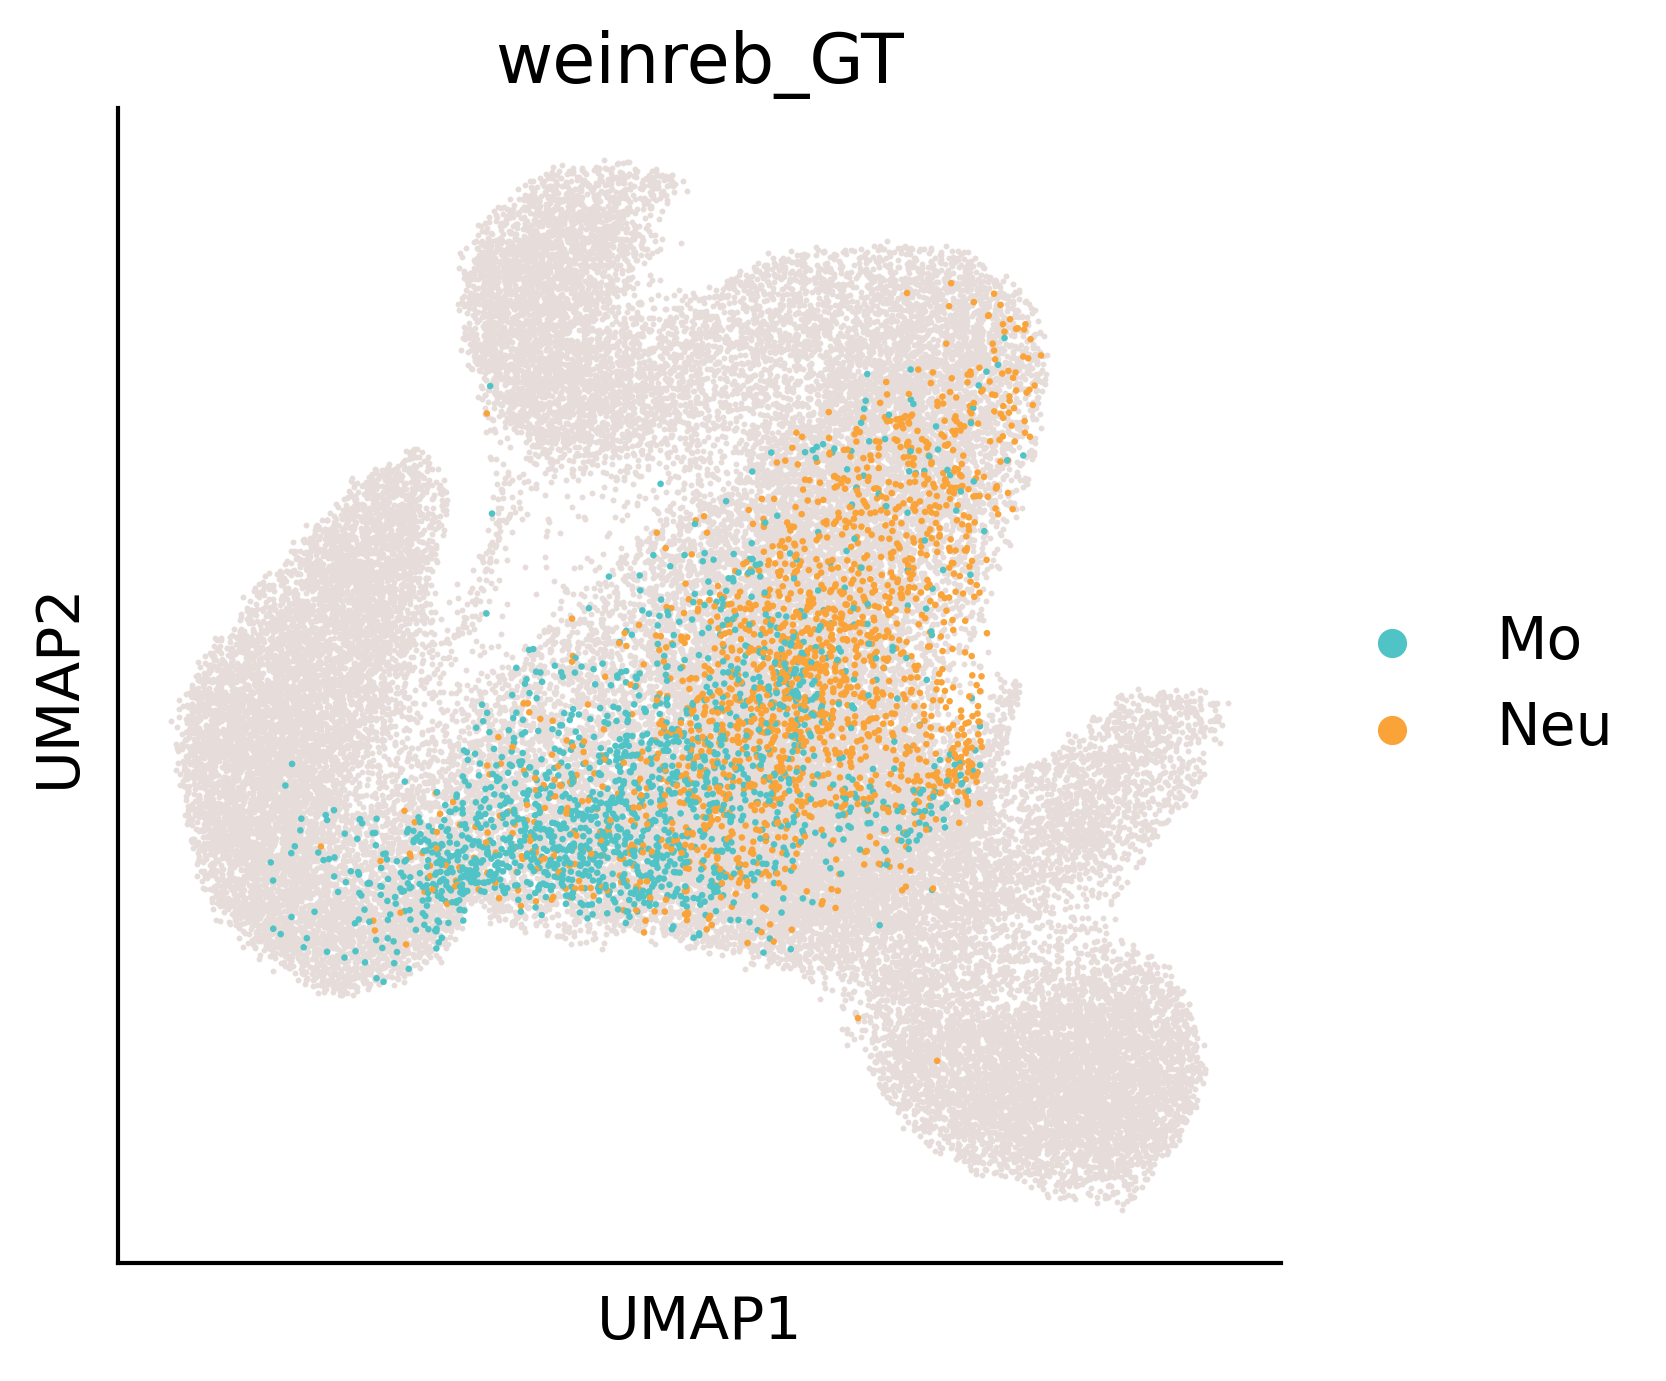

In [64]:
fig,ax=createFig()
fig.set_size_inches(5,5)
ax.scatter(
    weinreb_adata[weinreb_adata.obs['weinreb_GT'] == '-'].obsm["X_umap"][:,0],
    weinreb_adata[weinreb_adata.obs['weinreb_GT'] == '-'].obsm["X_umap"][:,1],
    s = 2, color='#E6DCD9', linewidth=0
)
sc.pl.umap(weinreb_adata[weinreb_adata.obs['weinreb_GT'] != '-'], 
           ax=ax, color='weinreb_GT', s=10, palette={
 'Baso': '#279E8F',
 'Ccr7_DC': '#ED2024',
 'Eos': '#854C9E',
 'Erythroid': '#9B724C',
 'Lymphoid': '#E43E96',
 'Mast': '#B5BD61',
 'Meg': '#AFC7E5',
 'Mo': '#50C3C6',
 'Neu_Mon': '#FFFFFF',
 'Neu': '#FAA339',
 'pDC': '#F69696',
 'undiff': '#E6DCD9',
 '-': '#E6DCD9'
})
ax.figure.savefig('/home/zhengtuo/songtao/DestinyNet/rebuttal6.1/noclone_GT.pdf', bbox_inches='tight')  # 修改为您的目标路径
plt.show()
plt.close(ax.figure)  # 关闭图形，释放资源


In [66]:
# weinreb_adata.obs['fate_pred_all_prob']='-'
# weinreb_adata.obs['fate_pred_all_prob']=weinreb_adata.obs['index'].map(dic_fate_prob)

# fig,ax=createFig()
# fig.set_size_inches(5,5)
# ax.scatter(
#     weinreb_adata[np.isnan(weinreb_adata.obs['fate_pred_all_prob'])].obsm["X_umap"][:,0],
#     weinreb_adata[np.isnan(weinreb_adata.obs['fate_pred_all_prob'])].obsm["X_umap"][:,1],
#     s = 2, color='#E6DCD9', linewidth=0
# )
# sc.pl.umap(weinreb_adata[weinreb_adata.obs['fate_pred_all_prob'] > 0], 
#            ax=ax, color='fate_pred_all_prob', s=10, cmap=make_colormap(['#50C3C6','#F7F7F7','#FAA339'])
# )
# #ax.figure.savefig('/home/zhengtuo/songtao/DestinyNet/rebuttal6.1/ednpoint_fate_pred_prob.pdf', bbox_inches='tight')  # 修改为您的目标路径
# plt.show()
# plt.close(ax.figure)

In [53]:
def compute_velocity_on_grid(
    X_emb,
    M_emb,
    density=None,
    smooth=None,
    n_neighbors=None,
    min_mass=None,
    autoscale=True,
    adjust_for_stream=False,
    cutoff_perc=None,
):
    # remove invalid cells
    idx_valid = np.isfinite(X_emb.sum(1) + M_emb.sum(1))
    X_emb = X_emb[idx_valid]
    M_emb = M_emb[idx_valid]

    # prepare grid
    n_obs, n_dim = X_emb.shape
    density = 0.5 if density is None else density
    smooth = 0.5 if smooth is None else smooth

    grs = []
    for dim_i in range(n_dim):
        m, M = np.min(X_emb[:, dim_i]), np.max(X_emb[:, dim_i])
        m = m - 0.01 * np.abs(M - m)
        M = M + 0.01 * np.abs(M - m)
        gr = np.linspace(m, M, int(50 * density))
        grs.append(gr)

    meshes_tuple = np.meshgrid(*grs)
    X_grid = np.vstack([i.flat for i in meshes_tuple]).T

    # estimate grid velocities
    if n_neighbors is None:
        n_neighbors = int(n_obs / 50)
    nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
    nn.fit(X_emb)
    dists, neighs = nn.kneighbors(X_grid)

    scale = np.mean([(g[1] - g[0]) for g in grs]) * smooth
    weight = normal.pdf(x=dists, scale=scale)
    p_mass = weight.sum(1)

    V_grid = (M_emb[neighs] * weight[:, :, None]).sum(1)
    V_grid /= np.maximum(1, p_mass)[:, None]
    if min_mass is None:
        min_mass = 1

    if adjust_for_stream:
        X_grid = np.stack([np.unique(X_grid[:, 0]), np.unique(X_grid[:, 1])])
        ns = int(np.sqrt(len(V_grid[:, 0])))
        V_grid = V_grid.T.reshape(2, ns, ns)

        mass = np.sqrt((V_grid ** 2).sum(0))
        min_mass = 10 ** (min_mass - 6)  # default min_mass = 1e-5
        min_mass = np.clip(min_mass, None, np.max(mass) * 0.9)
        cutoff = mass.reshape(V_grid[0].shape) < min_mass

        if cutoff_perc is None:
            cutoff_perc = 5
        length = np.sum(np.mean(np.abs(M_emb[neighs]), axis=1), axis=1).T
        length = length.reshape(ns, ns)
        cutoff |= length < np.percentile(length, cutoff_perc)

        V_grid[0][cutoff] = np.nan
    else:
        min_mass *= np.percentile(p_mass, 99) / 100
        X_grid, V_grid = X_grid[p_mass > min_mass], V_grid[p_mass > min_mass]

        if autoscale:
            V_grid /= 3 * quiver_autoscale(X_grid, V_grid)

    return X_grid, V_grid

def quiver_autoscale(X_emb, V_emb):
    import matplotlib.pyplot as pl

    scale_factor = np.abs(X_emb).max()  # just so that it handles very large values
    fig, ax = pl.subplots()
    Q = ax.quiver(
        X_emb[:, 0] / scale_factor,
        X_emb[:, 1] / scale_factor,
        V_emb[:, 0],
        V_emb[:, 1],
        angles="xy",
        scale_units="xy",
        scale=None,
    )
    Q._init()
    fig.clf()
    pl.close(fig)
    return Q.scale / scale_factor



In [49]:
#对于所有undiff cell预测出来的neu/mon细胞，计算fate flow
import numpy as np
from scipy.stats import norm as normal
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from tqdm import trange
import scanpy as sc
xkey = 'geneEnc'
mkey = 'genemap'

#只取了undiff+monocyte+neutrophil算fate flow (从undiff->mon, or undiff->neu)
weinreb_adata_to_plot = weinreb_adata[
    list(map(lambda x: x in ['undiff','Monocyte','Neutrophil'], weinreb_adata.obs['state_info']))
]
sc.pp.neighbors(weinreb_adata_to_plot)
X = weinreb_adata_to_plot.obsm[xkey][:,0,:]
M = weinreb_adata_to_plot.obsm[mkey][:,0,:]
N = weinreb_adata_to_plot.obsp['connectivities']
E = weinreb_adata_to_plot.obsm["X_emb_old"]
norm = lambda x: (x-min(x))/(max(x)-min(x))
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X)
dE = []
for i in trange(N.shape[0]):
    indices = np.argwhere(np.array(N[i].toarray().flatten())).flatten()
    # cosine_similarities = cosine_similarity(
    #    repeat(M[i], 'd -> n d', n = len(indices))-X[i], 
    #    X[indices]-X[i]
    # )[0]
    # gk = norm(np.exp(-((E[indices,0] - E[i,0]) ** 2 + ((E[indices,1] - E[i,1]) ** 2)) / (2 * 0.5 ** 2)))
    # qt = np.quantile(cosine_similarities, 0.1)
    # cosine_similarities = np.array(list(map(lambda x: x if x > qt else 0, cosine_similarities)))
    # cosine_similarities = norm(cosine_similarities)
    # dE.append(((E[indices] - E[i]).T * cosine_similarities.T).mean(1))
    D,I = nn.kneighbors( np.array([M[i]]) )
    dE.append( (E[I][0] - E[i]).mean(0))
dE = np.vstack(dE)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 39568/39568 [17:23<00:00, 37.92it/s]


In [54]:
weinreb_adata[np.isnan(weinreb_adata.obs['fate_pred_all_prob'])]
weinreb_adata_to_compare = weinreb_adata[~np.isnan(weinreb_adata.obs['fate_pred_all_prob'])]
indices = np.array(list(map(lambda x: x in weinreb_adata_to_compare.obs.index, weinreb_adata_to_plot.obs.index)))
E = weinreb_adata_to_plot.obsm["X_umap"]
gE, gdE = compute_velocity_on_grid(E[indices],dE[indices], density=3, adjust_for_stream=True,smooth=True)
weinreb_adata_to_plot.uns['E'] = E
weinreb_adata_to_plot.uns['dE'] = dE
weinreb_adata_to_plot.uns['gE'] = gE
weinreb_adata_to_plot.uns['gdE'] = gdE
gE = weinreb_adata_to_plot.uns['gE']
gdE = weinreb_adata_to_plot.uns['gdE']


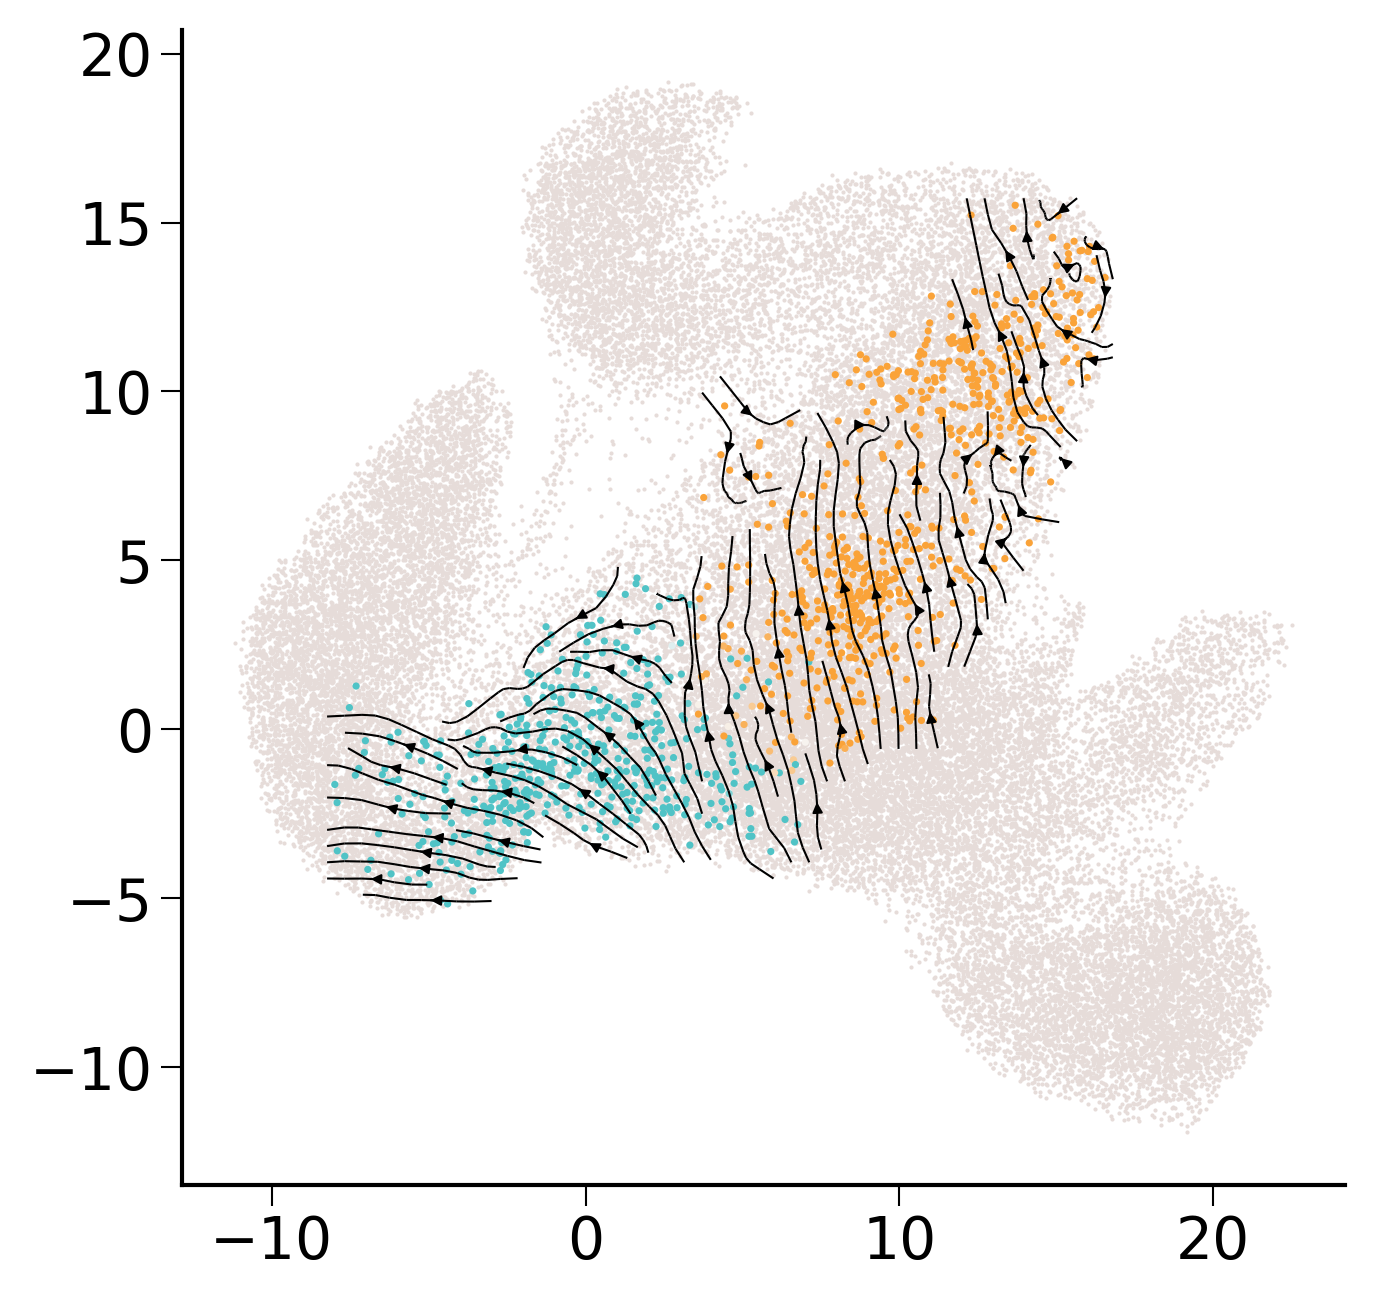

In [60]:
from matplotlib.backends.backend_pdf import PdfPages

E = weinreb_adata_to_plot.obsm["X_umap"]
gE, gdE = compute_velocity_on_grid(E[indices],dE[indices], density=3, adjust_for_stream=True,smooth=True)
weinreb_adata_to_plot.uns['E'] = E
weinreb_adata_to_plot.uns['dE'] = dE
weinreb_adata_to_plot.uns['gE'] = gE
weinreb_adata_to_plot.uns['gdE'] = gdE
gE = weinreb_adata_to_plot.uns['gE']
gdE = -weinreb_adata_to_plot.uns['gdE']
xkey = 'geneEnc'
mkey = 'genemap'
X = weinreb_adata_to_plot.obsm[xkey][:,0,:]
M = weinreb_adata_to_plot.obsm[mkey][:,0,:]
N = weinreb_adata_to_plot.obsp['connectivities']
E = weinreb_adata_to_plot.obsm["X_umap"]


# gE, gdE = biddy_adata.uns['gE'], biddy_adata.uns['gdE']
# gE, gdE = compute_velocity_on_grid(E,dE,density=2, adjust_for_stream=True,smooth=True)
fig,ax=createFig()
fig.set_size_inches(5,5)
palette = palette={
 'Baso': '#279E8F',
 'Ccr7_DC': '#ED2024',
 'Eos': '#854C9E',
 'Erythroid': '#9B724C',
 'Lymphoid': '#E43E96',
 'Mast': '#B5BD61',
 'Meg': '#AFC7E5',
 'Monocyte': '#50C3C6',
 'Neu_Mon': '#FFFFFF',
 'Neutrophil': '#FAA339',
 'pDC': '#F69696',
 'undiff': '#E6DCD9'
}
palette['Mo'] = palette['Monocyte']
palette['Neu'] = palette['Neutrophil']
palette['-'] = '#A8A7A8'


ax.scatter(weinreb_adata.obsm["X_umap"][:,0], weinreb_adata.obsm["X_umap"][:,1], 
           color='#E6DCD9', s=1, linewidths=0)

# Values for the colorbar
c_values = weinreb_adata_to_plot.obs['fate_pred_all_prob'].values

# Scatter for the data with color values
sc = ax.scatter(E[:,0], E[:,1],
                s=3,
                linewidths=0,
                c=c_values,  # Here you use the fate_pred_all_prob values for the color
                cmap=make_colormap(['#50C3C6','#F7F7F7','#FAA339']))  # This is an example colormap, you can choose another

'''
i=np.random.choice(list(map(lambda z: z[0], filter(lambda x: x[1],enumerate(tmp)))), 1)
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=80)
nn.fit(X)
D,I = nn.kneighbors(M[i])
e = E[I][0]
'''

E = weinreb_adata_to_plot.obsm["X_umap"]
# ax.scatter(E[i,0],E[i,1],color='red')
# sns.kdeplot(e[:,0],e[:,1],ax=ax, fill=True, alpha=0.5, cmap='Reds')

stream_kwargs = {
        "linewidth": 0.5,
        "density": 1.5,
        "zorder": 3,
        "color": "#000000",
        "arrowsize": 0.5,
        "arrowstyle": "-|>",
        "maxlength":  1,
        "integration_direction":  "both",
}

x_min, y_min = weinreb_adata_to_plot.obsm["X_umap"].min(0)
x_max, y_max = weinreb_adata_to_plot.obsm["X_umap"].max(0)
avail = ((gE[0] > x_min) | (gE[0] > y_min)) | ((gE[1] < x_max) | (gE[1] < y_max))

ax.streamplot(
    np.meshgrid(gE[0],gE[1])[0][avail],
    np.meshgrid(gE[0],gE[1])[1][avail],
    gdE[0][np.argwhere(avail).flatten(),:][:,np.argwhere(avail).flatten()],
    gdE[1][np.argwhere(avail).flatten(),:][:,np.argwhere(avail).flatten()],
    **stream_kwargs
)
with PdfPages('/home/zhengtuo/songtao/DestinyNet/rebuttal6.1/noclone_streamplot.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')